## The Data
- Airport List of attributes per each airport<br/>

- Cancelations Cancelation dataset list cancelations and diversion per each year from 2004 to 2014<br/>

- Operations Operations dataset lists delays, departures, arrivals and other operational metrics<br/>

#### Step 1: Load the python libraries that you will need for this project 

In [494]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)

import psycopg2
from sqlalchemy import create_engine

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#### Step 2: Examine your data 

In [448]:
engine = create_engine('postgresql://localhost:5432/archivedb')

In [449]:
conn = engine.connect()
conn.execute("commit")
conn.execute("create database archivedb")
conn.close()

In [450]:
airport_data = pd.read_csv("../assets/airports.csv")
airport_data.head()

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [451]:
# Archive airport data
airport_data.to_sql('airport_archive', engine, if_exists='replace')

In [452]:
# Extract the appropriate data for further analysis while maintaining original CSV file
airports = airport_data[["LocID", "AP_NAME", "FAA REGION", "CITY", "STATE", "Latitude", "Longitude"]]

In [453]:
# Rename the column names
airports.columns = ["Airport", "Name", "FAA Region", "City", "Location", "Latitude", "Longitude"]

In [454]:
# Drop null values based on the length of the "Airport" column
airports = airports.dropna(subset = ['Airport'], axis = 0)

In [455]:
# Combine the Latitude and Longitude columns into a single column as tuples
airports['Coordinates'] = list(zip(airports.Latitude, airports.Longitude))

In [456]:
# Filter data
airports = airports[["Airport", "Name", "FAA Region", "City", "Location", "Coordinates"]]

In [457]:
airports.shape

(5152, 6)

In [458]:
airports.head()

,Airport,Name,FAA Region,City,Location,Coordinates
0,STX,HENRY E ROHLSEN,ASO,CHRISTIANSTED,VI,"(17.701556, -64.801722)"
1,X64,PATILLAS,ASO,PATILLAS,PR,"(17.982189, -66.01933)"
2,PSE,MERCEDITA,ASO,PONCE,PR,"(18.008306, -66.563028)"
3,VQS,ANTONIO RIVERA RODRIGUEZ,ASO,ISLA DE VIEQUES,PR,"(18.134811, -65.493617)"
4,X63,HUMACAO,ASO,HUMACAO,PR,"(18.138017, -65.800718)"


In [446]:
airport_operations = pd.read_csv("../assets/Airport_operations.csv")
airport_operations.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [459]:
# Archive airport operations data
airport_operations.to_sql('operations_archive', engine, if_exists='replace')

In [460]:
# 
operations = airport_operations

In [461]:
# 
operations.columns = ["Airport", "Year", "Total Departures", "Total Arrivals", 
                      "Gate Departures Percent On Time", "Airport Departures Percent On Time", 
                      "Gate Arrivals Percent On Time", "Gate Departures Average Delay", 
                      "Taxi-Out Average Time", "Taxi-Out Average Delay", "Departure Average Delay", 
                      "Airborne Average Delay", "Taxi-In Average Delay", "Block Average Delay", 
                      "Gate Arrival Average Delay"]

In [462]:
operations.shape

(841, 15)

In [463]:
operations.head()

,Airport,Year,Total Departures,Total Arrivals,Gate Departures Percent On Time,Airport Departures Percent On Time,Gate Arrivals Percent On Time,Gate Departures Average Delay,Taxi-Out Average Time,Taxi-Out Average Delay,Departure Average Delay,Airborne Average Delay,Taxi-In Average Delay,Block Average Delay,Gate Arrival Average Delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [307]:
airport_cancellations = pd.read_csv("../assets/airport_cancellations.csv")
airport_cancellations.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [464]:
# Archive airport cancellations data
cancellations.to_sql('cancellations_archive', engine, if_exists='replace')

In [465]:
cancellations = airport_cancellations

In [466]:
cancellations["Year"] = cancellations["Year"].astype('int')

In [467]:
cancellations[["Year", "Departure Cancellations", "Arrival Cancellations", "Departure Diversions", "Arrival Diversions"]] = cancellations[["Year", "Departure Cancellations", "Arrival Cancellations", "Departure Diversions", "Arrival Diversions"]].astype('int')

In [468]:
cancellations.shape

(805, 6)

In [469]:
cancellations.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004,242,235,71,46
1,ABQ,2005,221,190,61,33
2,ABQ,2006,392,329,71,124
3,ABQ,2007,366,304,107,45
4,ABQ,2008,333,300,79,42


### Intro: Write a problem statement / aim for this project

In [546]:
# Taxi-Out time is the root of delays

### Part 1: Create a PostgreSQL database 

## Staging Database

Create a database where we can house our airport data

In [240]:
engine = create_engine('postgresql://localhost:5432/projectdb')

In [233]:
conn = engine.connect()
conn.execute("commit")
conn.execute("create database projectdb")
conn.close()

Load our csv files into tables

In [265]:
airports.to_sql('airports', engine, if_exists='replace')

In [266]:
cancellations.to_sql('cancellations', engine, if_exists='replace')

In [267]:
operations.to_sql('operations', engine, if_exists='replace')

Join airport_cancellations.csv and airports.csv into one table

In [281]:
%load_ext sql

In [261]:
%sql postgresql://localhost:5432/projectdb

'Connected: None@projectdb'

Query the database for our intial data

In [326]:
data = cancellations.merge(operations, on=['Airport', 'Year'])

In [327]:
data = data.merge(airports, on='Airport')

In [328]:
data.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Total Departures,Total Arrivals,Gate Departures Percent On Time,Airport Departures Percent On Time,Gate Arrivals Percent On Time,Gate Departures Average Delay,Taxi-Out Average Time,Taxi-Out Average Delay,Departure Average Delay,Airborne Average Delay,Taxi-In Average Delay,Block Average Delay,Gate Arrival Average Delay,Name,FAA Region,City,Location,Coordinates
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"


In [329]:
# Check for null values
data.isnull().sum()

Airport                               0
Year                                  0
Departure Cancellations               0
Arrival Cancellations                 0
Departure Diversions                  0
Arrival Diversions                    0
Total Departures                      0
Total Arrivals                        0
Gate Departures Percent On Time       0
Airport Departures Percent On Time    0
Gate Arrivals Percent On Time         0
Gate Departures Average Delay         0
Taxi-Out Average Time                 0
Taxi-Out Average Delay                0
Departure Average Delay               0
Airborne Average Delay                0
Taxi-In Average Delay                 0
Block Average Delay                   0
Gate Arrival Average Delay            0
Name                                  0
FAA Region                            0
City                                  0
Location                              0
Coordinates                           0
dtype: int64

In [330]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 24 columns):
Airport                               799 non-null object
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
Total Departures                      799 non-null int64
Total Arrivals                        799 non-null int64
Gate Departures Percent On Time       799 non-null float64
Airport Departures Percent On Time    799 non-null float64
Gate Arrivals Percent On Time         799 non-null float64
Gate Departures Average Delay         799 non-null float64
Taxi-Out Average Time                 799 non-null float64
Taxi-Out Average Delay                799 non-null float64
Departure Average Delay               799 non-null float64
Airborne Averag

#### 1.2 What are the risks and assumptions of our data? 

In [545]:
# Taxi-Out time is a factor of number of flights and runways
# FAA regions will be used to separate airports.
# Not able to determine if weather caused departures.
# Gate departure delays could be due to late arrivals and weather.

### Part 2: Exploratory Data Analysis

### Plot and Describe the Data

In [471]:
data["FAA Region"].value_counts()

### FAA Region 
Western Pacific (AWP)<br/>
Southern (ASO)<br/>
Eastern (AEA)<br/>
Great Lakes (AGL)<br/>
Southwest (ASW)<br/>
Northwest Mountain (ANM)<br/>
New England (ANE)<br/>
Central (ACE)<br/>
Alaska (AAL)<br/>
<br/>

##### Not in data :
Mike Monroney Aeronautical Center (AMC)<br/>
William J. Hughes Technical Center (ACT)

In [332]:
data.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Total Departures,Total Arrivals,Gate Departures Percent On Time,Airport Departures Percent On Time,Gate Arrivals Percent On Time,Gate Departures Average Delay,Taxi-Out Average Time,Taxi-Out Average Delay,Departure Average Delay,Airborne Average Delay,Taxi-In Average Delay,Block Average Delay,Gate Arrival Average Delay,Name,FAA Region,City,Location,Coordinates
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,ALBUQUERQUE INTL SUNPORT,ASW,ALBUQUERQUE,NM,"(35.040194, -106.609194)"


### Create two pivot tables: by "Airport" and by "Year"

In [344]:
airport = pd.pivot_table(data, index=['Airport'], values=['Departure Cancellations','Arrival Cancellations',
                                                         'Departure Diversions','Arrival Diversions',
                                                         'Total Departures', 'Total Arrivals',
                                                         'Departure Average Delay', 'Taxi-Out Average Time'],
                                                         aggfunc=[np.sum])

airport.columns = airport.columns.droplevel()
airport.reset_index(inplace=True)

In [345]:
airport.sort_values(by='Taxi-Out Average Time', ascending=False).head()

,Airport,Arrival Cancellations,Arrival Diversions,Departure Average Delay,Departure Cancellations,Departure Diversions,Taxi-Out Average Time,Total Arrivals,Total Departures
30,JFK,27171.0,4401.0,301.74,27352.0,3014.0,314.74,2085879,2102854
33,LGA,50157.0,5691.0,283.53,50663.0,2796.0,272.35,2045739,2043854
20,EWR,47906.0,5285.0,306.54,46661.0,3582.0,269.33,2201788,2218791
52,PHL,21546.0,3076.0,255.02,21944.0,2449.0,221.14,2445557,2449424
2,ATL,80490.0,9594.0,220.76,72186.0,9729.0,217.45,5122886,5159044


In [346]:
airport.sort_values(by='Departure Average Delay', ascending=False).head()

,Airport,Arrival Cancellations,Arrival Diversions,Departure Average Delay,Departure Cancellations,Departure Diversions,Taxi-Out Average Time,Total Arrivals,Total Departures
20,EWR,47906.0,5285.0,306.54,46661.0,3582.0,269.33,2201788,2218791
30,JFK,27171.0,4401.0,301.74,27352.0,3014.0,314.74,2085879,2102854
33,LGA,50157.0,5691.0,283.53,50663.0,2796.0,272.35,2045739,2043854
24,HPN,3129.0,837.0,270.24,3646.0,302.0,151.97,351165,347900
52,PHL,21546.0,3076.0,255.02,21944.0,2449.0,221.14,2445557,2449424


In [292]:
ewr = data.loc[data['Airport'] == 'EWR']
ewr.iloc[:,:19]

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Total Departures,Total Arrivals,Gate Departures Percent On Time,Airport Departures Percent On Time,Gate Arrivals Percent On Time,Gate Departures Average Delay,Taxi-Out Average Time,Taxi-Out Average Delay,Departure Average Delay,Airborne Average Delay,Taxi-In Average Delay,Block Average Delay,Gate Arrival Average Delay
220,EWR,2004.0,3883.0,3981.0,295.0,418.0,212226,209575,0.7921,0.5698,0.7147,12.87,25.93,12.73,23.59,5.93,2.21,6.04,18.54
221,EWR,2005.0,4622.0,4696.0,317.0,472.0,211790,209551,0.7421,0.5255,0.6528,16.02,25.96,12.31,26.62,6.22,2.63,7.52,23.18
222,EWR,2006.0,4557.0,4650.0,346.0,756.0,214805,213118,0.7189,0.4525,0.6383,18.07,29.13,15.42,31.80,6.21,2.65,7.25,24.79
223,EWR,2007.0,5926.0,5992.0,345.0,718.0,209019,207435,0.6903,0.4335,0.6180,21.24,28.74,15.22,35.34,5.49,2.80,6.89,27.78
224,EWR,2008.0,4511.0,4608.0,324.0,545.0,207145,206270,0.7034,0.4371,0.6404,20.24,28.98,15.63,34.57,4.83,3.18,5.64,26.55
225,EWR,2009.0,2969.0,3013.0,348.0,484.0,196298,195150,0.7408,0.4957,0.6701,17.99,25.74,13.09,29.70,4.66,2.15,5.12,24.88
226,EWR,2010.0,3706.0,3750.0,299.0,391.0,192614,191370,0.7540,0.6100,0.7203,16.22,20.94,8.10,23.19,4.11,1.96,4.10,19.37
227,EWR,2011.0,4502.0,4525.0,286.0,491.0,192879,191645,0.7318,0.5873,0.6690,17.77,20.99,8.49,25.08,4.85,2.54,5.14,22.32
228,EWR,2012.0,3821.0,3915.0,315.0,310.0,196105,195110,0.7217,0.5716,0.7009,18.06,21.33,8.71,25.66,3.90,2.86,3.61,19.91
229,EWR,2013.0,3350.0,3579.0,358.0,461.0,196365,194358,0.7264,0.5815,0.7095,18.13,20.91,8.41,25.53,3.54,2.51,3.46,20.23


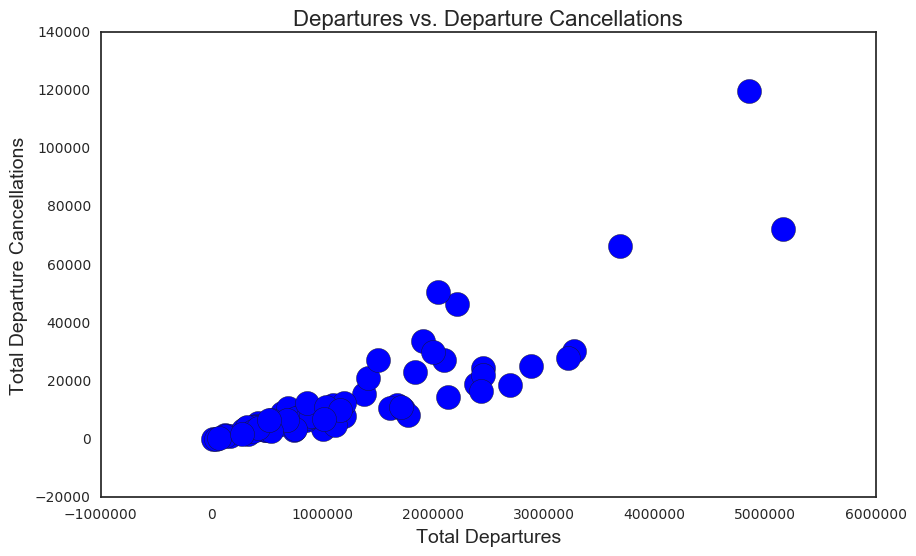

In [474]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(airport['Total Departures'], airport['Departure Cancellations'], c='blue', s=300)

axes.set_title('Departures vs. Departure Cancellations', fontsize=16)
axes.set_xlabel('Total Departures', fontsize=14)
axes.set_ylabel('Total Departure Cancellations', fontsize=14)

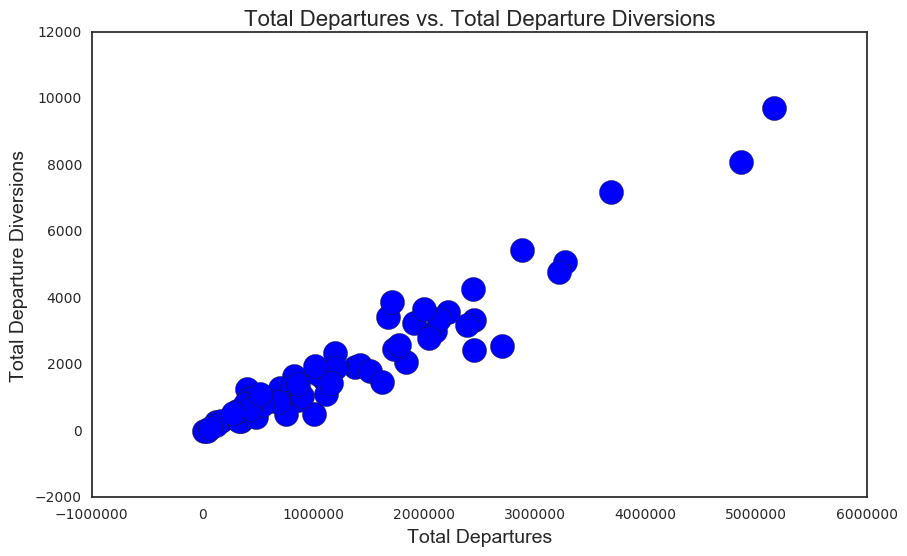

In [475]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(airport['Total Departures'], airport['Departure Diversions'], c='blue', s=300)

axes.set_title('Total Departures vs. Total Departure Diversions', fontsize=16)
axes.set_xlabel('Total Departures', fontsize=14)
axes.set_ylabel('Total Departure Diversions', fontsize=14)

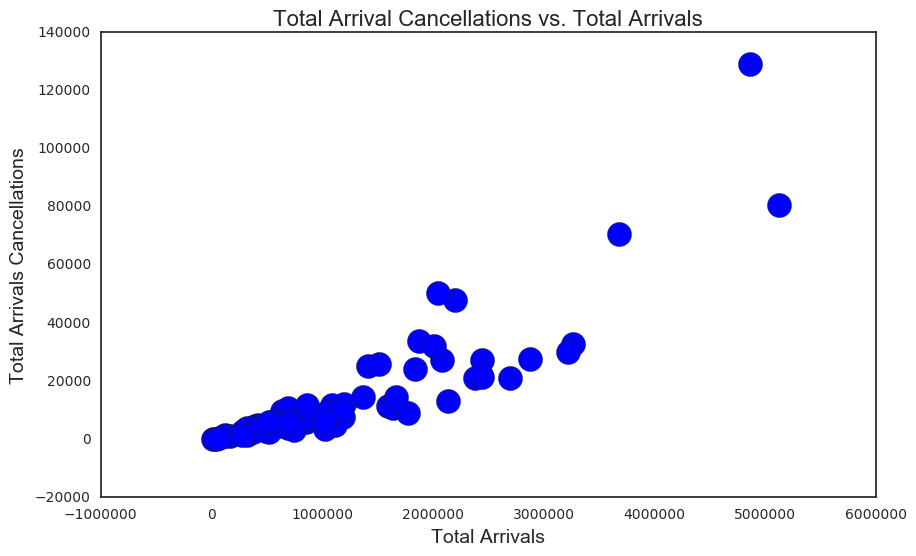

In [476]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(airport["Total Arrivals"], airport["Arrival Cancellations"], c='blue', s=300)

axes.set_title('Total Arrival Cancellations vs. Total Arrivals', fontsize=16)
axes.set_xlabel('Total Arrivals', fontsize=14)
axes.set_ylabel('Total Arrivals Cancellations', fontsize=14)

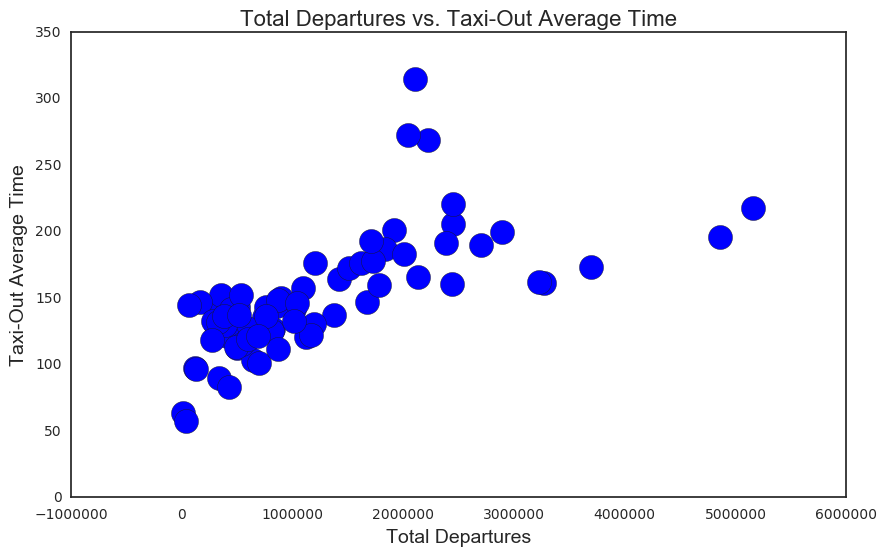

In [478]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(airport['Total Departures'], airport['Taxi-Out Average Time'], c='blue', s=300)

axes.set_title('Total Departures vs. Taxi-Out Average Time', fontsize=16)
axes.set_xlabel('Total Departures', fontsize=14)
axes.set_ylabel('Taxi-Out Average Time', fontsize=14)

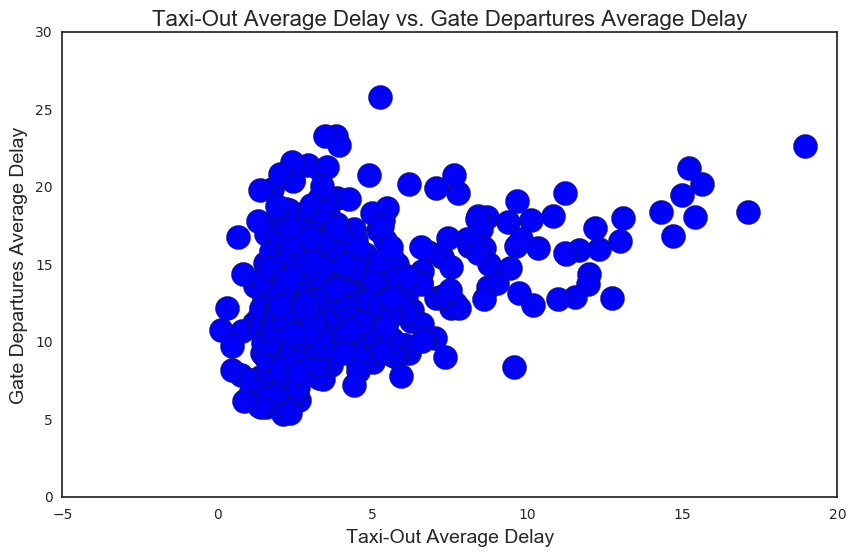

In [489]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(data['Taxi-Out Average Delay'], data['Gate Departures Average Delay'], c='blue', s=300)

axes.set_title('Taxi-Out Average Delay vs. Gate Departures Average Delay', fontsize=16)
axes.set_xlabel('Taxi-Out Average Delay', fontsize=14)
axes.set_ylabel('Gate Departures Average Delay', fontsize=14)

In [480]:
data['EWR Flag'] = np.where(data['Airport']=='EWR', 1, 0)

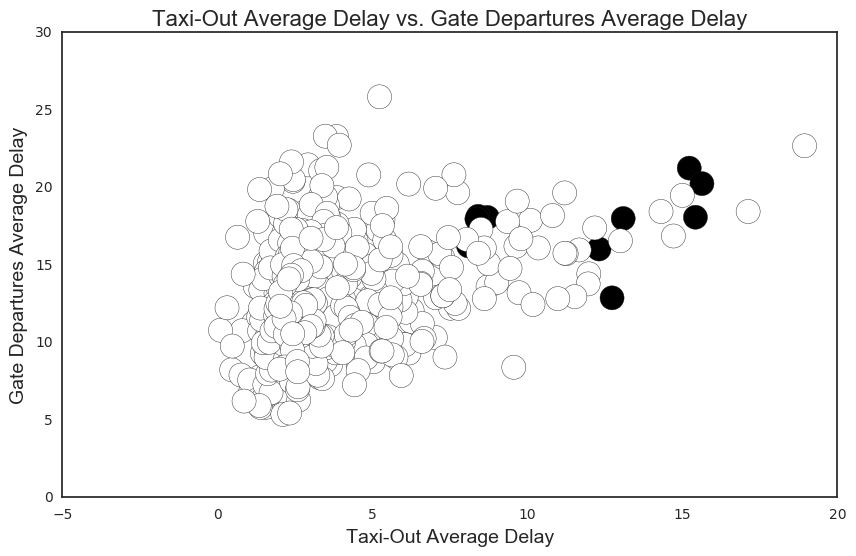

In [490]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(data['Taxi-Out Average Delay'], data['Gate Departures Average Delay'], c=data['EWR Flag'], s=300)

axes.set_title('Taxi-Out Average Delay vs. Gate Departures Average Delay', fontsize=16)
axes.set_xlabel('Taxi-Out Average Delay', fontsize=14)
axes.set_ylabel('Gate Departures Average Delay', fontsize=14)

In [491]:
year = pd.pivot_table(data, index=['Year'], values=['Departure Cancellations','Arrival Cancellations',
                                                    'Departure Diversions','Arrival Diversions',
                                                    'Total Departures', 'Total Arrivals'],
                                                    aggfunc=[np.sum])

year.columns = year.columns.droplevel()
year.reset_index(inplace=True)

In [492]:
year

,Year,Arrival Cancellations,Arrival Diversions,Departure Cancellations,Departure Diversions,Total Arrivals,Total Departures
0,2004.0,105582.0,11423.0,102169.0,11408.0,8403068,8448021
1,2005.0,109796.0,11656.0,106594.0,11796.0,8994706,9046718
2,2006.0,99683.0,13903.0,96773.0,13451.0,8769358,8832600
3,2007.0,131836.0,14572.0,128206.0,14126.0,8937146,8958208
4,2008.0,114124.0,14493.0,110654.0,14548.0,8531547,8556044
5,2009.0,73857.0,12471.0,70752.0,13144.0,7888150,7919350
6,2010.0,94325.0,12431.0,91099.0,13129.0,7867412,7900851
7,2011.0,96955.0,11778.0,94394.0,12484.0,7870747,7899518
8,2012.0,66180.0,10043.0,64120.0,10797.0,7740598,7762301
9,2013.0,77375.0,11496.0,74560.0,12023.0,7671298,7697539


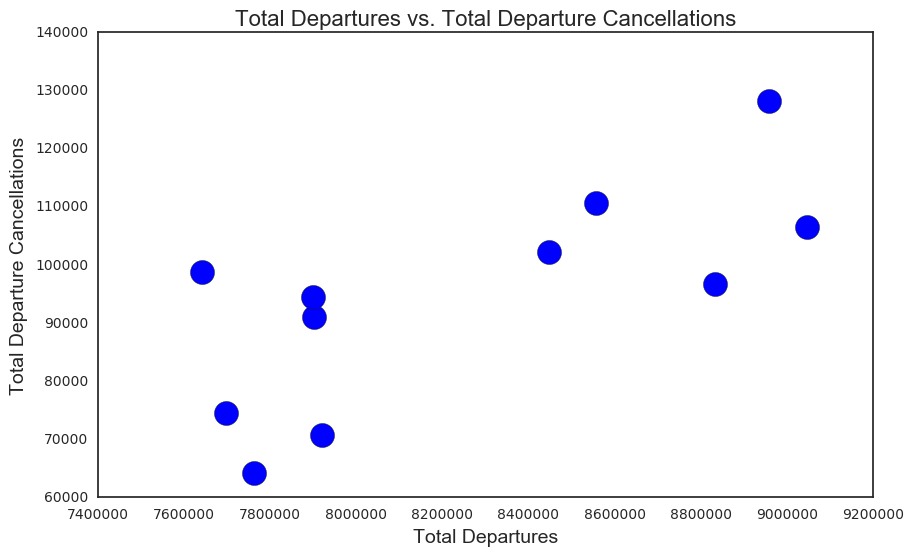

In [484]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(year["Total Departures"], year["Departure Cancellations"], c='blue', s=300)

axes.set_title('Total Departures vs. Total Departure Cancellations', fontsize=16)
axes.set_xlabel('Total Departures', fontsize=14)
axes.set_ylabel('Total Departure Cancellations', fontsize=14)

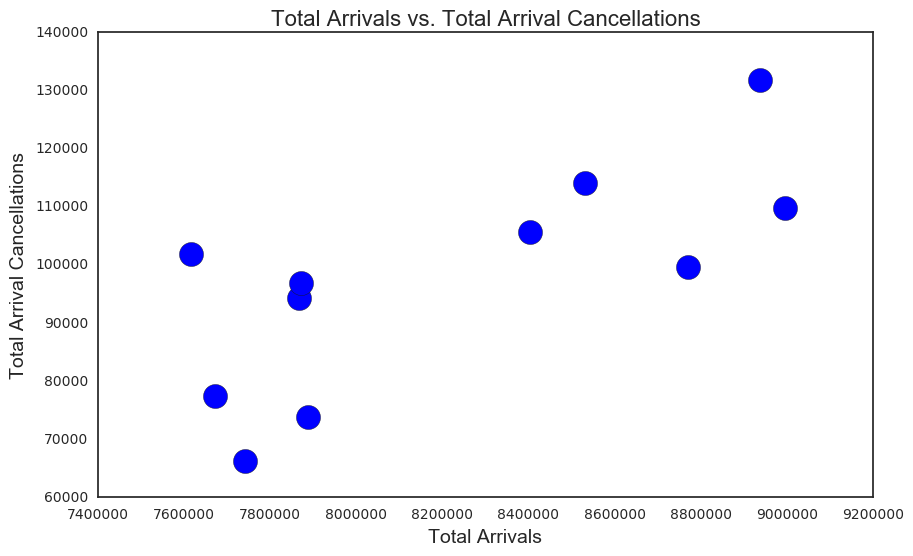

In [485]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(year["Total Arrivals"], year["Arrival Cancellations"], c='blue', s=300)

axes.set_title('Total Arrivals vs. Total Arrival Cancellations', fontsize=16)
axes.set_xlabel('Total Arrivals', fontsize=14)
axes.set_ylabel('Total Arrival Cancellations', fontsize=14)

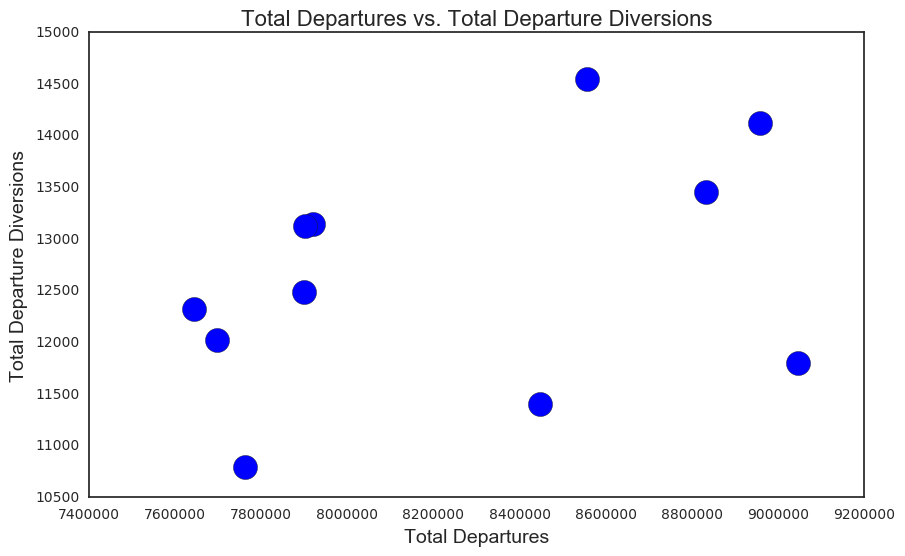

In [486]:
fig = plt.figure(figsize=(10,6))
axes = fig.gca()

axes.scatter(year["Total Departures"], year["Departure Diversions"], c='blue', s=300)

axes.set_title('Total Departures vs. Total Departure Diversions', fontsize=16)
axes.set_xlabel('Total Departures', fontsize=14)
axes.set_ylabel('Total Departure Diversions', fontsize=14)

### Part 3: Data Mining

#### Create Dummy Variables

In [487]:
# Create dummies for Airport code, FAA Region, State, and AP Type
data = pd.concat([data, pd.get_dummies(data['Airport'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data['FAA Region'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data['Location'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data['Name'])], axis = 1)

In [488]:
data.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Total Departures,Total Arrivals,Gate Departures Percent On Time,Airport Departures Percent On Time,Gate Arrivals Percent On Time,Gate Departures Average Delay,Taxi-Out Average Time,Taxi-Out Average Delay,Departure Average Delay,Airborne Average Delay,Taxi-In Average Delay,Block Average Delay,Gate Arrival Average Delay,Name,FAA Region,City,Location,Coordinates,EWR Flag,ABQ,ANC,ATL,AUS,BDL,BHM,BNA,BOS,BUF,BUR,BWI,CLE,CLT,CVG,DAL,DAY,DCA,DEN,DFW,DTW,EWR,FLL,HNL,HOU,HPN,IAD,IAH,IND,ISP,JAX,JFK,LAS,LAX,LGA,LGB,MCI,MCO,MDW,MEM,MHT,MIA,MKE,MSP,MSY,OAK,OGG,OMA,ONT,ORD,OXR,PBI,PDX,PHL,PHX,PIT,PSP,PVD,RDU,RFD,RSW,SAN,SAT,SDF,SEA,SFO,SJC,SJU,SLC,SMF,SNA,STL,SWF,TPA,TUS,AAL,ACE,AEA,AGL,ANE,ANM,ASO,ASW,AWP,ABQ,ANC,ATL,AUS,BDL,BHM,BNA,BOS,BUF,BUR,BWI,CLE,CLT,CVG,DAL,DAY,DCA,DEN,DFW,DTW,EWR,FLL,HNL,HOU,HPN,IAD,IAH,IND,ISP,JAX,JFK,LAS,LAX,LGA,LGB,MCI,MCO,MDW,MEM,MHT,MIA,MKE,MSP,MSY,OAK,OGG,OMA,ONT,ORD,OXR,PBI,PDX,PHL,PHX,PIT,PSP,PVD,RDU,RFD,RSW,SAN,SAT,SDF,SEA,SFO,SJC,SJU,SLC,SMF,SNA,STL,SWF,TPA,TUS,AAL,ACE,AEA,AGL,ANE,ANM,ASO,ASW,AWP,AK,AL,AZ,CA,CO,CT,DC,FL,GA,HI,IL,IN,KY,LA,MA,MD,MI,MN,MO,NC,NE,NH,NJ,NM,NV,NY,OH,OR,PA,PR,RI,TN,TX,UT,WA,WI,ALBUQUERQUE INTL SUNPORT,AUSTIN-BERGSTROM INTL,BALTIMORE/WASHINGTON INTL THURGOOD MARSHAL,BIRMINGHAM-SHUTTLESWORTH INTL,BOB HOPE,BRADLEY INTL,BUFFALO NIAGARA INTL,CHARLOTTE/DOUGLAS INTL,CHICAGO MIDWAY INTL,CHICAGO O'HARE INTL,CHICAGO/ROCKFORD INTL,CINCINNATI/NORTHERN KENTUCKY INTL,CLEVELAND-HOPKINS INTL,DALLAS LOVE FIELD,DALLAS/FORT WORTH INTL,DENVER INTL,DETROIT METROPOLITAN WAYNE COUNTY,EPPLEY AIRFIELD,FORT LAUDERDALE/HOLLYWOOD INTL,GENERAL EDWARD LAWRENCE LOGAN INTL,GENERAL MITCHELL INTL,GEORGE BUSH INTERCONTINENTAL/HOUSTON,HARTSFIELD - JACKSON ATLANTA INTL,HONOLULU INTL,INDIANAPOLIS INTL,JACKSONVILLE INTL,JAMES M COX DAYTON INTL,JOHN F KENNEDY INTL,JOHN WAYNE AIRPORT-ORANGE COUNTY,KAHULUI,KANSAS CITY INTL,LA GUARDIA,LAMBERT-ST LOUIS INTL,LONG BEACH /DAUGHERTY FIELD/,LONG ISLAND MAC ARTHUR,LOS ANGELES INTL,LOUIS ARMSTRONG NEW ORLEANS INTL,LOUISVILLE INTL-STANDIFORD FIELD,LUIS MUNOZ MARIN INTL,MANCHESTER,MC CARRAN INTL,MEMPHIS INTL,METROPOLITAN OAKLAND INTL,MIAMI INTL,MINNEAPOLIS-ST PAUL INTL/WOLD-CHAMBERLAIN,NASHVILLE INTL,NEWARK LIBERTY INTL,NORMAN Y. MINETA SAN JOSE INTL,ONTARIO INTL,ORLANDO INTL,OXNARD,PALM BEACH INTL,PALM SPRINGS INTL,PHILADELPHIA INTL,PHOENIX SKY HARBOR INTL,PITTSBURGH INTL,PORTLAND INTL,RALEIGH-DURHAM INTL,RONALD REAGAN WASHINGTON NATIONAL,SACRAMENTO INTL,SALT LAKE CITY INTL,SAN ANTONIO INTL,SAN DIEGO INTL,SAN FRANCISCO INTL,SEATTLE-TACOMA INTL,SOUTHWEST FLORIDA INTL,STEWART INTL,TAMPA INTL,TED STEVENS ANCHORAGE INTL,THEODORE FRANCIS GREEN STATE,TUCSON INTL,WASHINGTON DULLES INTL,WESTCHESTER COUNTY,WILLIAM P HOBBY,ABQ,ANC,ATL,AUS,BDL,BHM,BNA,BOS,BUF,BUR,BWI,CLE,CLT,CVG,DAL,DAY,DCA,DEN,DFW,DTW,EWR,FLL,HNL,HOU,HPN,IAD,IAH,IND,ISP,JAX,JFK,LAS,LAX,LGA,LGB,MCI,MCO,MDW,MEM,MHT,MIA,MKE,MSP,MSY,OAK,OGG,OMA,ONT,ORD,OXR,PBI,PDX,PHL,PHX,PIT,PSP,PVD,RDU,RFD,RSW,SAN,SAT,SDF,SEA,SFO,SJC,SJU,SLC,SMF,SNA,STL,SWF,TPA,TUS,AAL,ACE,AEA,AGL,ANE,ANM,ASO,ASW,AWP,AK,AL,AZ,CA,CO,CT,DC,FL,GA,HI,IL,IN,KY,LA,MA,MD,MI,MN,MO,NC,NE,NH,NJ,NM,NV,NY,OH,OR,PA,PR,RI,TN,TX,UT,WA,WI,ALBUQUERQUE INTL SUNPORT,AUSTIN-BERGSTROM INTL,BALTIMORE/WASHINGTON INTL THURGOOD MARSHAL,BIRMINGHAM-SHUTTLESWORTH INTL,BOB HOPE,BRADLEY INTL,BUFFALO NIAGARA INTL,CHARLOTTE/DOUGLAS INTL,CHICAGO MIDWAY INTL,CHICAGO O'HARE INTL,CHICAGO/ROCKFORD INTL,CINCINNATI/NORTHERN KENTUCKY INTL,CLEVELAND-HOPKINS INTL,DALLAS LOVE FIELD,DALLAS/FORT WORTH INTL,DENVER INTL,DETROIT METROPOLITAN WAYNE COUNTY,EPPLEY AIRFIELD,FORT LAUDERDALE/HOLLYWOOD INTL,GENERAL EDWARD LAWRENCE LOGAN INTL,GENERAL MITCHELL INTL,GEORGE BUSH INTERCONTINENTAL/HOUSTON,HARTSFIELD - JACKSON ATLANTA INTL,HONOLULU INTL,INDIANAPOLIS INTL,JACKSONVILLE INTL,JAMES M COX DAYTON INTL,JOHN F KENNEDY INTL,JOHN WAYNE AIRPORT-ORANGE COUNTY,KAHULUI,KANSAS CITY INTL,LA GUARDIA,LAMBERT-ST LOUIS INTL

### Part 4: Define the Data

### Find correlations in the data

In [493]:
# Create dataset of only arrival data to inspect potential correlation
arrivals = data[[u'Airport', u'Total Arrivals', u'Gate Arrivals Percent On Time',
                 u'Airborne Average Delay', u'Taxi-In Average Delay',
                 u'Block Average Delay', u'Gate Arrival Average Delay', 
                 u'Arrival Cancellations', u'Arrival Diversions']]

# Create dataset of only departure data to inspect potential correlation
departures = data[[u'Airport', u'Total Departures', u'Gate Departures Percent On Time',
                   u'Airport Departures Percent On Time', u'Taxi-Out Average Time', 
                   u'Taxi-Out Average Delay', u'Departure Average Delay', u'Departure Cancellations', 
                   u'Departure Diversions']]

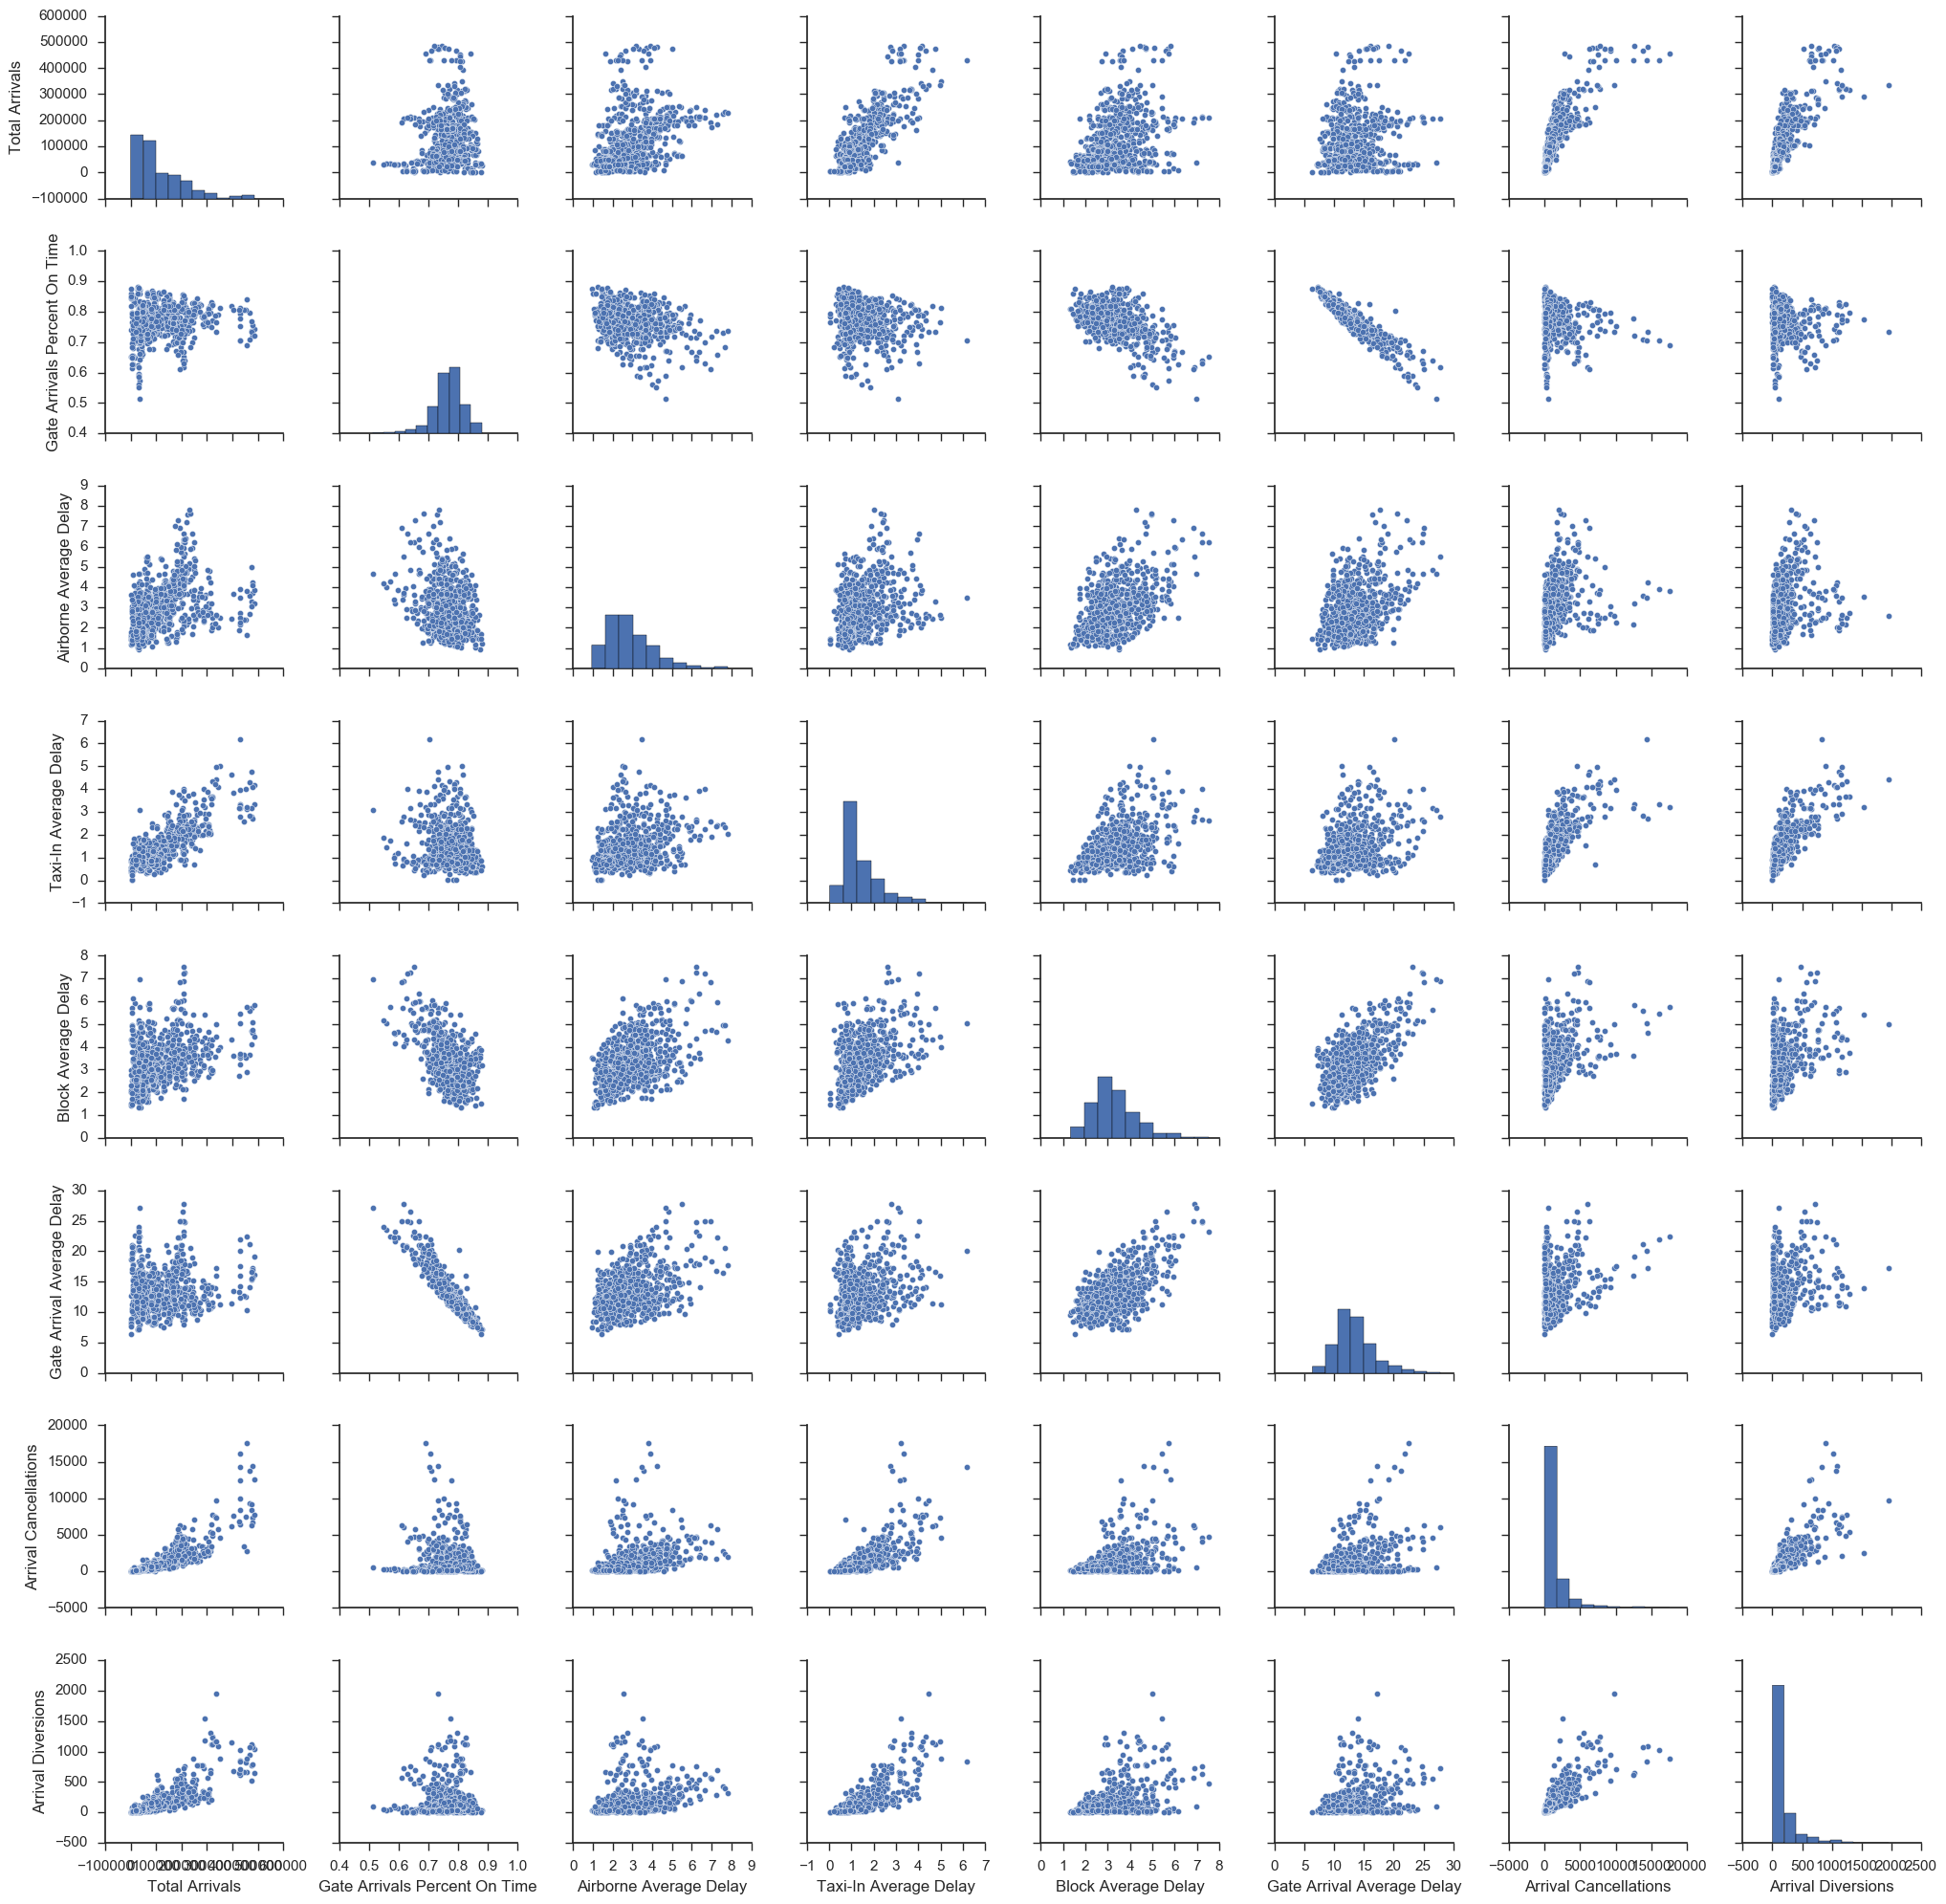

In [375]:
sns.pairplot(arrivals)

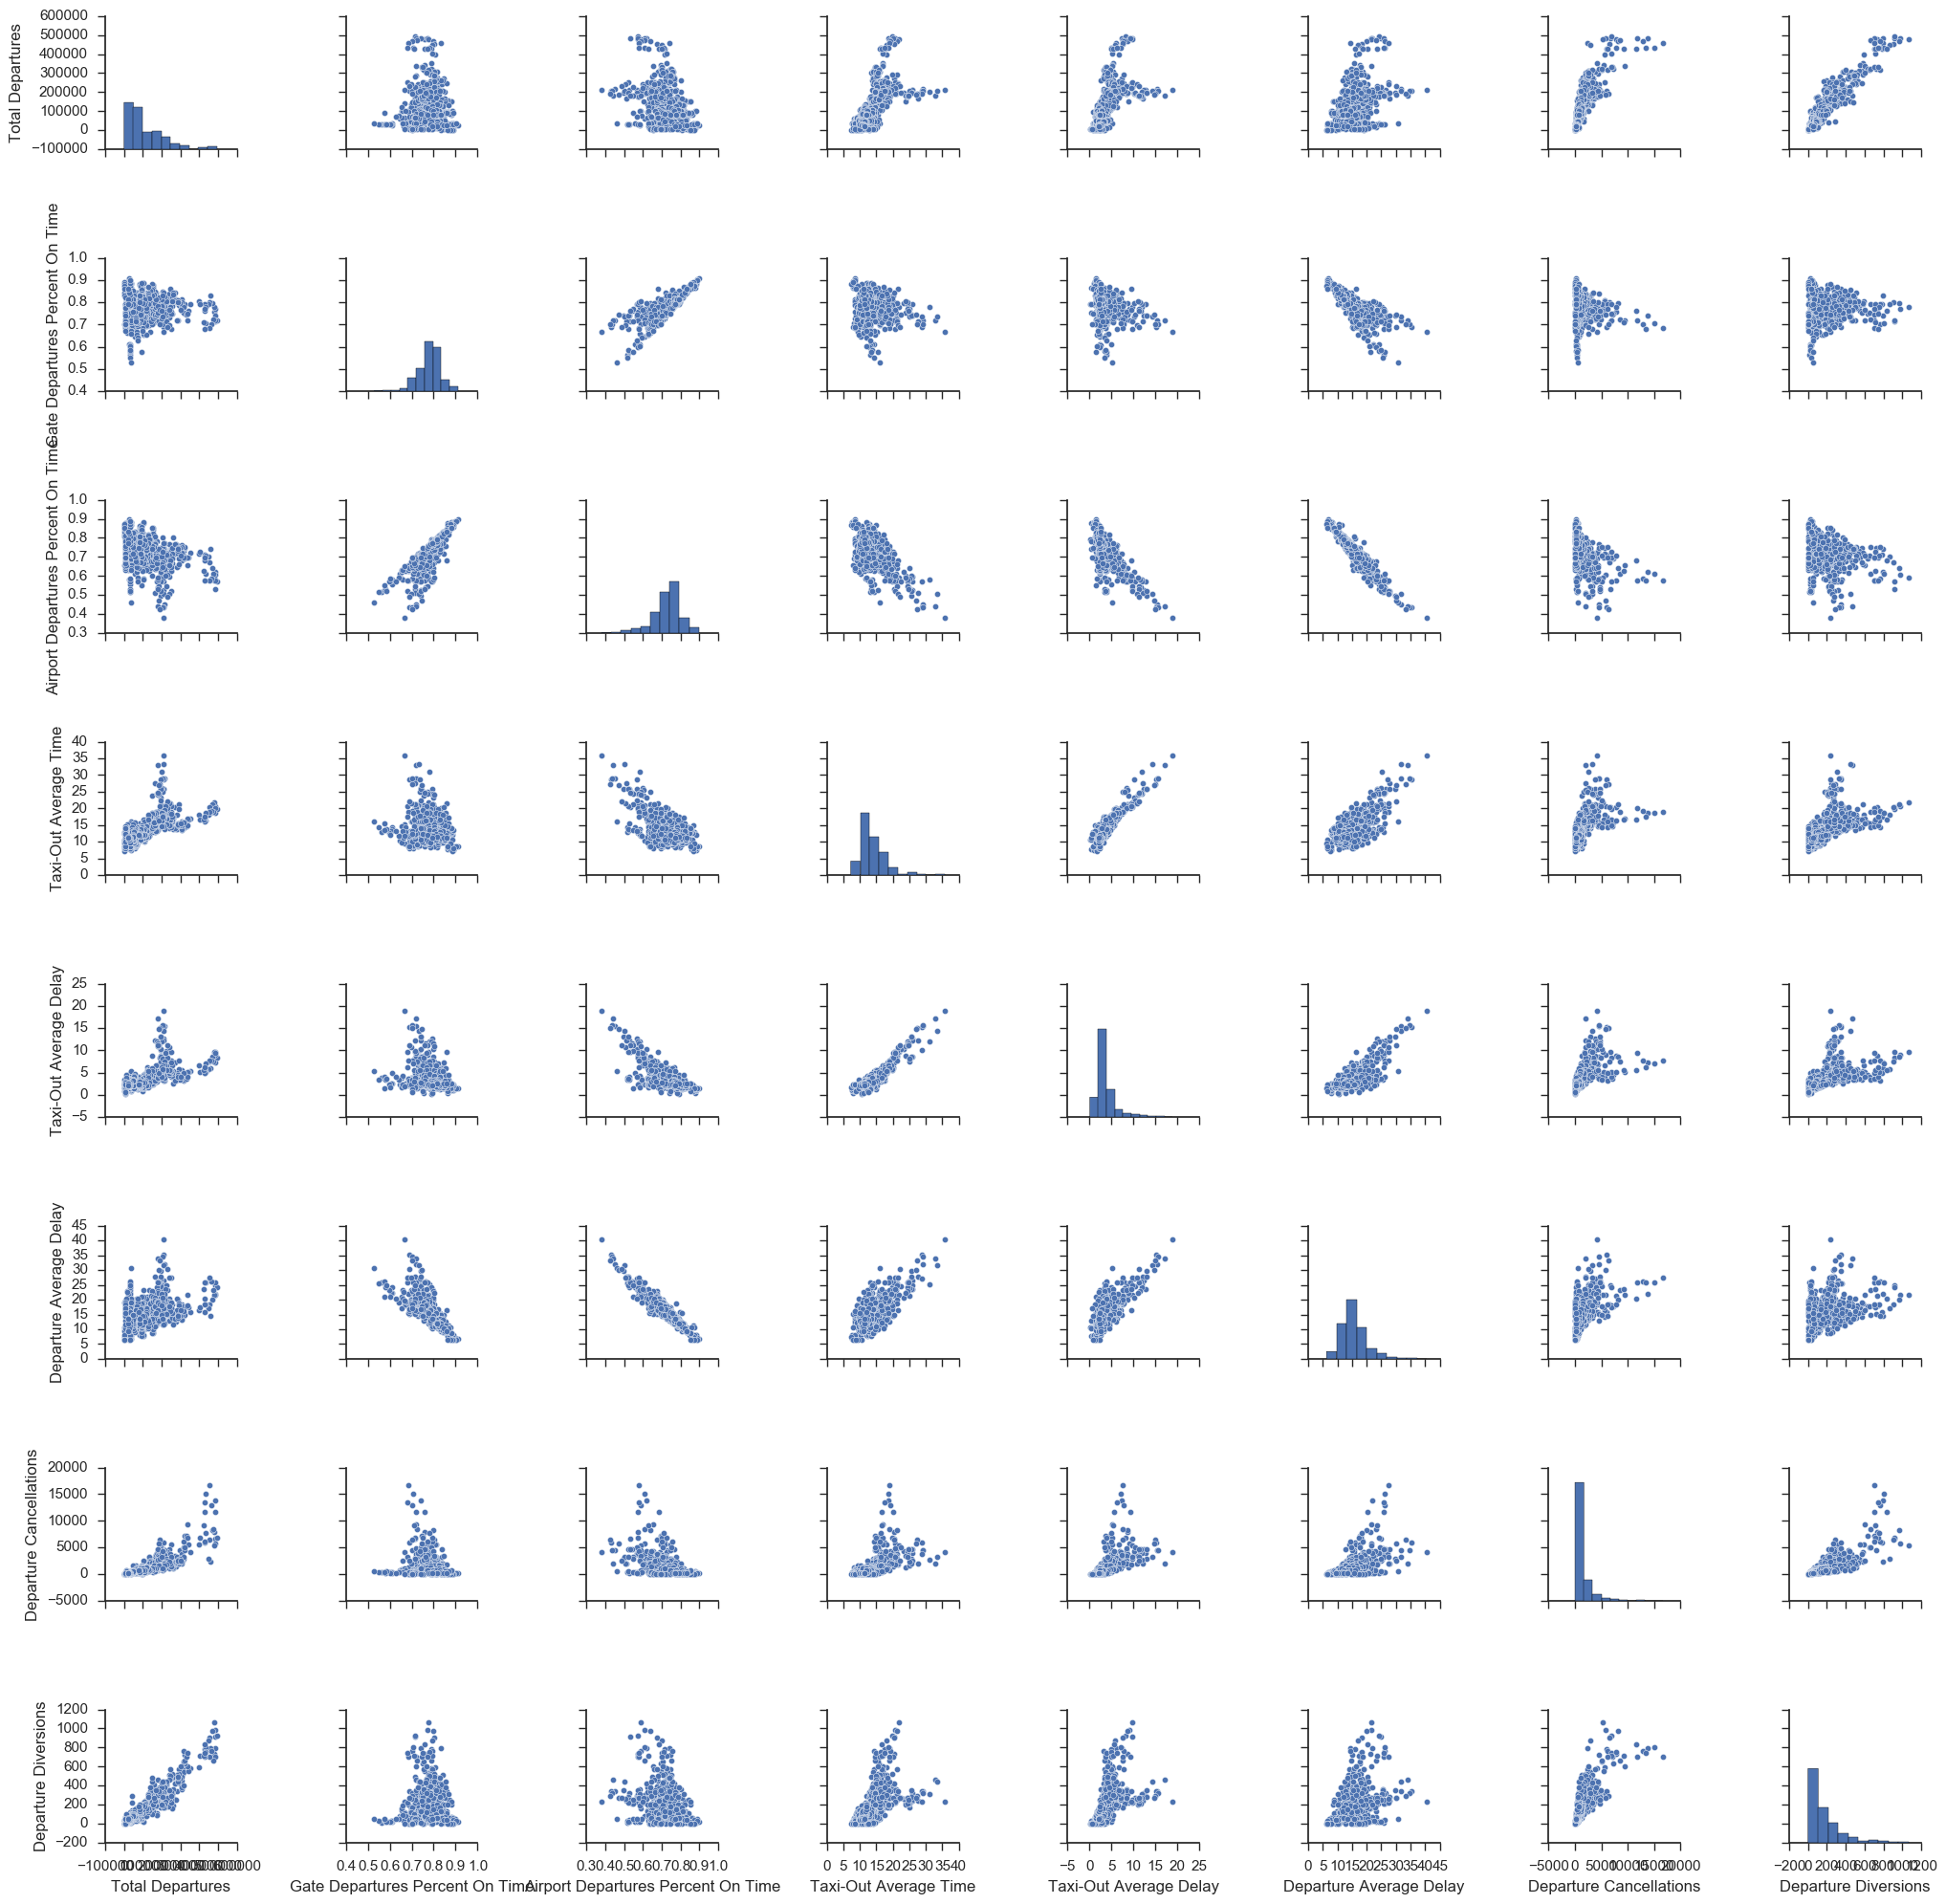

In [376]:
sns.pairplot(departures)

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [428]:
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn import metrics

### Covariance Matrix

In [495]:
# Use scaling
from sklearn import preprocessing

X = data[[u'Gate Arrivals Percent On Time',
          u'Airborne Average Delay', u'Taxi-In Average Delay',
          u'Block Average Delay', u'Gate Arrival Average Delay', u'Arrival Cancellations', u'Arrival Diversions',
        u'Gate Departures Percent On Time',
         u'Airport Departures Percent On Time', u'Taxi-Out Average Time',
         u'Taxi-Out Average Delay', u'Departure Average Delay',
         u'Departure Cancellations',u'Departure Diversions']]

xStand = preprocessing.scale(data[[u'Gate Arrivals Percent On Time',
          u'Airborne Average Delay', u'Taxi-In Average Delay',
          u'Block Average Delay', u'Gate Arrival Average Delay', u'Arrival Cancellations', u'Arrival Diversions',
        u'Gate Departures Percent On Time',
         u'Airport Departures Percent On Time', u'Taxi-Out Average Time',
         u'Taxi-Out Average Delay', u'Departure Average Delay',
         u'Departure Cancellations',u'Departure Diversions']])

Create the covariance matrix from the standardized x-values and decompose these values to find the eigenvalues and eigenvectors


In [498]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

### Eigenpairs


In [497]:
# Check your eigenvalues and eigenvectors:
print(eigenValues)
print(eigenVectors)

[  7.66650822e+00   3.05645135e+00   1.11650900e+00   6.22137736e-01
   5.10145308e-01   3.71786877e-01   2.02107033e-01   1.73360637e-01
   1.39130182e-01   8.61351819e-02   5.55181587e-02   1.12311624e-02
   4.88658789e-03   1.63642504e-03]
[[ -1.89464885e-01   4.42998740e-01   1.73743874e-01  -2.51092911e-01
    2.22975961e-02   1.04073436e-01  -2.32215502e-01  -2.49380065e-01
    1.07269218e-02  -4.03082351e-01  -4.54675242e-01   3.93204852e-01
    1.52471547e-01  -1.37434749e-04]
 [  2.28401675e-01  -4.71217455e-02   5.02660906e-01  -2.41139550e-01
   -6.45867504e-01   3.57704245e-01   1.31013272e-01   2.64598935e-01
    3.78743527e-02  -1.59692005e-02   2.61089535e-02  -1.10606798e-02
   -5.07421339e-03   1.57084366e-03]
 [  2.78126503e-01   2.50476373e-01  -6.66432015e-02   9.39085373e-02
    3.71824636e-01   3.12794970e-01  -2.45004021e-01   5.52258086e-01
    4.95008235e-01  -8.84372928e-03  -1.23920822e-03   2.00720179e-02
   -2.97071440e-03   3.50381812e-03]
 [  2.56148152e-

Find the principal componants, find the eigenpairs, and sort them from highest to lowest.

In [436]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

7.66650821978
3.05645134665
1.11650900391
0.622137736435
0.510145308105
0.371786876697
0.202107033349
0.173360636726
0.139130182112
0.0861351818539
0.0555181587373
0.0112311623552
0.00488658789466
0.00163642504159


### Explained Variance

In [499]:
# Explained Variance
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [500]:
print(varExpl)

[54.692236361408085, 21.804471434147221, 7.9650830066418639, 4.4382792211222348, 3.6393344883570329, 2.6522968675517697, 1.4418148812127538, 1.2367404622497551, 0.99254322658182992, 0.61448127229909244, 0.39606195845154096, 0.080122184511711284, 0.03486051439244614, 0.011674121072655858]


Calculate the explained variance and the Cumulative explained variance

In [501]:
cvarex = np.cumsum(varExpl)

In [502]:
print(cvarex)

[ 54.69223636  76.4967078   84.4617908   88.90007002  92.53940451
  95.19170138  96.63351626  97.87025672  98.86279995  99.47728122
  99.87334318  99.95346536  99.98832588 100.        ]


84.5% of the behavior can be explained by the first three principal componants

### Perform the PCA
Now that we have discovered the principal componants, we have an educated idea on how many componants to pass to the function.

In [503]:
# Split the data into three components
pcask = PCA(n_components=3)
# Use the eigenvectors to transform xStand onto new axes
Y = pcask.fit_transform(xStand) 
print(pcask.fit(xStand).components_) # See the eigenvectors

[[-0.18946488  0.22840168  0.2781265   0.25614815  0.25306253  0.27767853
   0.26270275 -0.19320774 -0.31098778  0.29733783  0.30802161  0.31897233
   0.280777    0.24678323]
 [-0.44299874  0.04712175 -0.25047637  0.11456515  0.34862284 -0.27223831
  -0.2923603  -0.37875559 -0.22513738 -0.08440699 -0.0635923   0.22171701
  -0.26067161 -0.34946053]
 [-0.17374387 -0.50266091  0.0666432  -0.22478283  0.11307146  0.25844918
   0.20361056 -0.36536699 -0.03130798 -0.41074423 -0.37424943  0.02525183
   0.25208512  0.1835941 ]]


In [504]:
# Create a dataframe from the PCA results
Ydf = pd.DataFrame(Y, columns=['PC1','PC2','PC3'])

Create a new dataframe that uses the "Airport" and "Year" from the original set and join the PCA results to form a new set

In [505]:
airport_data = data[['Airport', 'Year']]

In [506]:
airport_pca = airport_data.join(Ydf, on=None, how='left')

In [507]:
Ydf.head()

,PC1,PC2,PC3
0,-2.413326,-0.151235,0.036783
1,-2.784130,-0.445966,0.041231
2,-2.162480,0.035461,0.433867
3,-1.713457,0.184566,0.277530
4,-2.303655,-0.198086,0.231824


In [508]:
x = airport_pca['PC1']
y = airport_pca['PC2']
z = airport_pca['PC3']

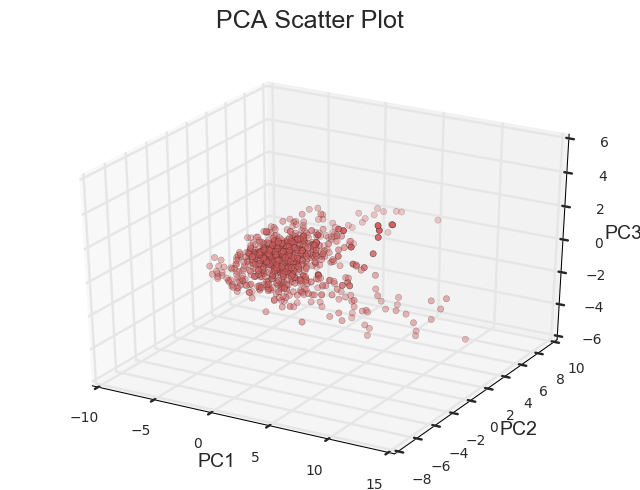

In [509]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
sns.set(style='white',palette='muted',color_codes=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')
fig.suptitle('PCA Scatter Plot', fontsize=18)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)

### Cluster with K-Means
Set up the k-means clustering analysis

In [510]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(X)

Compute the labels and centroids

In [511]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [512]:
print(centroids)

[[  7.69038972e-01   2.78401894e+00   1.26893099e+00   3.18939107e+00
    1.31318809e+01   8.94317997e+02   1.25791610e+02   7.81322057e-01
    7.35690122e-01   1.33602706e+01   3.32882273e+00   1.51633018e+01
    8.83857916e+02   1.44265223e+02]
 [  7.40075000e-01   4.00266667e+00   3.20283333e+00   4.54016667e+00
    1.70860000e+01   6.84355000e+03   7.17916667e+02   7.52035000e-01
    6.19401667e-01   2.01865000e+01   8.04916667e+00   2.23570000e+01
    6.41635000e+03   5.43566667e+02]]


Compute the Silhoutte Score

In [513]:
metrics.silhouette_score(X, labels, metric='euclidean')

0.79985029206960268

In [514]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(xStand)

In [515]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [516]:
print(centroids)

[[ 0.13632734 -0.21607001 -0.30088977 -0.22168175 -0.21200402 -0.298712
  -0.30055795  0.1378137   0.27480753 -0.29815944 -0.30916664 -0.2810799
  -0.30141649 -0.27118091]
 [-0.70156147  1.11192952  1.54842506  1.14080837  1.09100529  1.53721792
   1.54671744 -0.70921051 -1.41420182  1.53437434  1.59101911  1.44648043
   1.55113564  1.39553868]]


In [517]:
metrics.silhouette_score(xStand, labels, metric='euclidean')

0.48410062465147075

In [518]:
airport_pca['cluster'] = pd.Series(clusters.labels_)

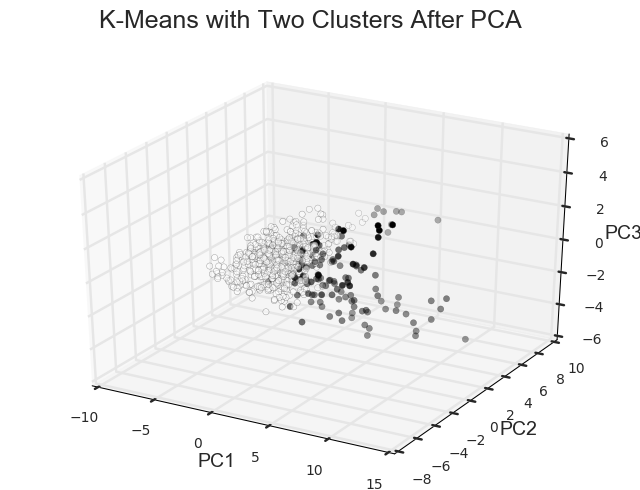

In [519]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, marker='o', c=airport_pca['cluster'])
fig.suptitle('K-Means with Two Clusters After PCA', fontsize=18)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)



In [520]:
df = pd.DataFrame(xStand)
df.columns=(u'Gate Arrivals Percent On Time',
          u'Airborne Average Delay', u'Taxi-In Average Delay',
          u'Block Average Delay', u'Gate Arrival Average Delay', u'Arrival Cancellations', u'Arrival Diversions',
          u'Gate Departures Percent On Time',
          u'Airport Departures Percent On Time', u'Taxi-Out Average Time',
          u'Taxi-Out Average Delay', u'Departure Average Delay',
          u'Departure Cancellations',u'Departure Diversions')

In [521]:
df['cluster'] = pd.Series(clusters.labels_)

In [522]:
df.head()

,Gate Arrivals Percent On Time,Airborne Average Delay,Taxi-In Average Delay,Block Average Delay,Gate Arrival Average Delay,Arrival Cancellations,Arrival Diversions,Gate Departures Percent On Time,Airport Departures Percent On Time,Taxi-Out Average Time,Taxi-Out Average Delay,Departure Average Delay,Departure Cancellations,Departure Diversions,cluster
0,0.500021,-0.355457,-0.683889,-0.749327,-0.787421,-0.558841,-0.542560,0.457014,0.709963,-1.047069,-0.536544,-0.826210,-0.574713,-0.598447,0
1,0.658531,-0.526543,-0.613645,-0.961737,-0.981290,-0.581577,-0.599323,0.667555,0.858688,-1.073359,-0.596479,-1.032562,-0.586128,-0.656408,0
2,0.153280,-0.646303,-0.672181,-0.638065,-0.495078,-0.511347,-0.201977,0.367055,0.640207,-1.047069,-0.652133,-0.773476,-0.493179,-0.598447,0
3,-0.042876,-0.586423,-0.145352,-0.233475,-0.221199,-0.523979,-0.546926,0.409163,0.571768,-0.928768,-0.549387,-0.631323,-0.507312,-0.389788,0
4,0.408878,-0.902931,-0.449742,-0.506573,-0.599706,-0.526000,-0.560025,0.596737,0.756029,-0.910365,-0.545106,-0.775769,-0.525249,-0.552079,0


In [523]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [524]:
x_clust = df.drop(df.columns[[14]], axis=1)
y = df['cluster']

In [525]:
X_train, X_test, y_train, y_test = train_test_split(x_clust, y, test_size= 0.3, random_state=42)

In [526]:
# Run DecisionTreeClassifier Model:
treeclass = DecisionTreeClassifier(random_state=1)
treeclass.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [527]:
# Predict on test Using DecisionTreeClassifier Model
preds = treeclass.predict(X_test)

In [528]:
# Create confusion matrix using Test set vs Predicted
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, preds)
cm

array([[186,   7],
       [  9,  38]])

In [529]:
# Print Cross Val Score
cross_val_score(treeclass, x_clust, y, cv=10, n_jobs=-1).mean()

0.93742088607594931

In [530]:
# Print feature importance
feature_importances = pd.DataFrame(treeclass.feature_importances_,
                                   index = x_clust.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
Departure Cancellations,0.548451
Airport Departures Percent On Time,0.211283
Taxi-Out Average Delay,0.150199
Taxi-Out Average Time,0.030177
Departure Average Delay,0.021224
Arrival Cancellations,0.014118
Arrival Diversions,0.013937
Taxi-In Average Delay,0.010612
Gate Arrivals Percent On Time,0.000000
Airborne Average Delay,0.000000


In [531]:
# Use RandomForest Models
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [532]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [533]:
rf_preds = rf.predict(X_test)

In [534]:
cm_rf = confusion_matrix(y_test, rf_preds)
cm_rf

array([[191,   2],
       [  9,  38]])

In [535]:
cross_val_score(rf, x_clust, y, cv=10, n_jobs=-1).mean()

0.95745253164556965

In [536]:
# Print feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_clust.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
Departure Cancellations,0.202869
Arrival Cancellations,0.180424
Taxi-In Average Delay,0.140934
Taxi-Out Average Time,0.076702
Taxi-Out Average Delay,0.075812
Gate Arrival Average Delay,0.058188
Gate Departures Percent On Time,0.057809
Airport Departures Percent On Time,0.051809
Departure Average Delay,0.039872
Block Average Delay,0.039642


In [537]:
from sklearn.ensemble import ExtraTreesClassifier

In [538]:
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

In [539]:
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [540]:
et_preds = et.predict(X_test)

In [541]:
cm_et = confusion_matrix(y_test, et_preds)
cm_et

array([[193,   0],
       [ 13,  34]])

In [542]:
cross_val_score(et, x_clust, y, cv=10, n_jobs=-1).mean()

0.95745253164556965

In [543]:
feature_importances = pd.DataFrame(et.feature_importances_,
                                   index = x_clust.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
Arrival Cancellations,0.185954
Taxi-In Average Delay,0.174228
Departure Average Delay,0.109919
Departure Diversions,0.100968
Taxi-Out Average Time,0.085584
Taxi-Out Average Delay,0.057818
Airport Departures Percent On Time,0.056629
Departure Cancellations,0.055264
Block Average Delay,0.046030
Gate Arrivals Percent On Time,0.040533
